## Importing Libraries

In [2]:
import pandas as pd
import numpy as np
import geopandas as gpd

import shapely
from shapely.geometry import Polygon
from shapely.geometry import Point
import geog

import folium
import geopy.distance

import forestci as fci


import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from descartes import PolygonPatch
import altair as alt

import folium

import random

# for the notebook only (not for JupyterLab) run this command once per session
alt.renderers.enable('notebook')

import warnings
warnings.filterwarnings('ignore')

## Defining consts

In [3]:
### Consts
datapath = '../rawdata/sensors/'
sensors_file = datapath + 'nodes.txt'

## Loading External Datasets

In [16]:
## loading 311
noiseComplaints = pd.read_pickle('../data/311/311.pkl')
noiseComplaints = gpd.GeoDataFrame(noiseComplaints, crs={'init' : 'epsg:4326'}, geometry='geometry')
noiseComplaints = noiseComplaints.to_crs({'init':'epsg:3857'}) 

## loading wind speed
windSpeed = pd.read_pickle('../data/weather/wind.pkl')
windSpeed = windSpeed.resample('H').agg({'Spd[Wind]': 'mean'})

## loading precipitation
precipitation = pd.read_pickle('../data/weather/precipitation.pkl')
precipitation = precipitation.resample('H').agg({'Amt[PrecipHourly1]': 'mean'})

## loading taxi
taxi = pd.read_pickle('../data/taxi/taxi.pkl')

# loading taxi regions
taxi_regions = gpd.read_file('zip://../assets/taxi_zones.zip')
taxi_regions = taxi_regions.to_crs({'init':'epsg:3857'}) 

## Pool of Sensors

In [7]:
poolOfSensors = ['sonycnode-b827eb0fedda.sonyc','sonycnode-b827eb132382.sonyc',
 'sonycnode-b827eb44506f.sonyc','sonycnode-b827eb73e772.sonyc','sonycnode-b827eb29eb77.sonyc',
 'sonycnode-b827eb815321.sonyc','sonycnode-b827eb820cfe.sonyc','sonycnode-b827ebf9d204.sonyc',
 'sonycnode-b827eb84deb5.sonyc','sonycnode-b827eb86d458.sonyc','sonycnode-b827eb8e2420.sonyc',
 'sonycnode-b827eb9bed23.sonyc','sonycnode-b827eb3e842e.sonyc','sonycnode-b827eb42bd4a.sonyc',
 'sonycnode-b827eb9d0e7f.sonyc','sonycnode-b827ebad073b.sonyc','sonycnode-b827ebb40450.sonyc',
 'sonycnode-b827ebc7f772.sonyc','sonycnode-b827ebefb215.sonyc']

# # poolOfSensors = list(sensors_datasets.keys())

# initialPool = ['sonycnode-b827eb0fedda.sonyc']

# usedSensors_guided = []
# usedSensors_random = []

# testingSet = ['sonycnode-b827eb132382.sonyc','sonycnode-b827eb44506f.sonyc','sonycnode-b827eb73e772.sonyc','sonycnode-b827eb29eb77.sonyc']

## Sensors in Manhattan

In [7]:
# sensors_geodf = gpd.GeoDataFrame(crs={'init': 'epsg:4326'})

# f = open(sensors_file)
# for line in f:
#     s, lat, lon = line.split(' ')
    
#     lat = float(lat)
#     lon = float(lon)
    
#     ## adding sensor to geodataframe
#     sensor_point = shapely.geometry.Point(lon, lat)
#     sensors_geodf = sensors_geodf.append({'sensorID': s, 'geometry':sensor_point}, ignore_index=True)
    
    
# sensors_geodf = sensors_geodf.to_crs({'init':'epsg:3857'})

# ## join taxi regions with sensors
# manhattan_regions = taxi_regions[taxi_regions['borough'] == 'Manhattan']
# manhattan_sensors = gpd.tools.sjoin(sensors_geodf, manhattan_regions, how='inner', op="within")

# ## closing file
# f.close()

## Reading datasets

In [18]:
sensors_datasets = {}

f = open(sensors_file)
for line in f:
    
    s, lat, lon = line.split(' ')
    lat = float(lat)
    lon = float(lon)

    if(s in poolOfSensors):
        
        print('Sensor: ', s)
        
        # creating empty timeseries
        df_timeseries = pd.DataFrame()
        df_timeseries['datetime'] = pd.date_range('2018-01-01', '2018-12-31', freq="1h")
        df_timeseries.set_index(['datetime'], inplace = True)

        # DOB data
        DOB_timeseries = pd.read_csv('../data/DOB/' + s + '.csv')
        DOB_timeseries['datetime'] = pd.to_datetime(DOB_timeseries['datetime'])
        DOB_timeseries.set_index('datetime', inplace=True)
                
        # Twitter data
        twitter_timeseries = pd.read_csv('../data/twitter/' + s + '.csv')
        twitter_timeseries['datetime'] = twitter_timeseries['datetime'].astype(str).str[:-6]
        twitter_timeseries['datetime'] = pd.to_datetime(twitter_timeseries['datetime'])
        twitter_timeseries.set_index('datetime', inplace=True)
        twitter_timeseries = twitter_timeseries.resample('H').agg('sum')
                
        # adding 311 data to the empty dataframe
        noiseComplaints_temp = noiseComplaints['2018-01-01':'2018-12-31']
        noiseComplaints_temp = spatialJoin(lat, lon, s, noiseComplaints_temp)            
        noiseComplaints_temp = noiseComplaints_temp.resample('H').agg({'Descriptor': 'count'})
        noiseComplaints_temp.rename({'Descriptor':'noise'}, inplace=True)
                
#         # wind data
#         windSpeed_temp = windSpeed['2018-01-01':'2018-12-31']
        
#         # precipitation data
#         precipitation_temp = precipitation['2018-01-01':'2018-12-31']
        
#         # taxi data
#         taxi_region = getSensorLocation(lat, lon)
#         taxi_temp = taxi[taxi['location'] == taxi_region]
#         taxi_temp = taxi_temp.resample('H').agg({'location': 'count'})
#         taxi_temp.rename({'location':'trips'}, inplace=True)
#         taxi_temp = taxi_temp['2018-01-01':'2018-12-31']
        
        # SPL measurements
        sensorData = pd.read_pickle(datapath + s + '.pkl')
    
        # calculating the average over one hour of SPL
        sensorData['dbas'] = sensorData['sum'] / sensorData['count']
        sensorData = sensorData[['dbas']]
        
        # adding cos and sin to the dataframe
        df_timeseries['hour'] = df_timeseries.index.hour
        df_timeseries['hour_sin'] = np.sin(df_timeseries['hour'])
        df_timeseries['hour_cos'] = np.cos(df_timeseries['hour'])
        
        df_timeseries['DOB'] = DOB_timeseries
        df_timeseries['twitter'] = twitter_timeseries
        df_timeseries['noise'] = noiseComplaints_temp 
#         df_timeseries['taxi'] = taxi_temp
#         df_timeseries['wind'] = windSpeed_temp
#         df_timeseries['precipitation'] = precipitation_temp
        df_timeseries['SPL'] = sensorData 
        
        df_timeseries = df_timeseries[ (df_timeseries['SPL'] < 90) & (df_timeseries['SPL'] > 60) ]
        df_timeseries.dropna(inplace=True)
        
        sensors_datasets[s] = {}
        
        start = '2018-01-01'
        end = '2018-12-31'
        periods = pd.date_range(start=start, end=end, periods=len(poolOfSensors))
        periods = periods.normalize()
        for i in range(1, len(periods)):
            start, end = periods[(i-1)], periods[i]
            sensors_datasets[s][(i-1)] = df_timeseries[start:end]
            
f.close()

Sensor:  sonycnode-b827eb0fedda.sonyc
Sensor:  sonycnode-b827eb132382.sonyc
Sensor:  sonycnode-b827eb29eb77.sonyc
Sensor:  sonycnode-b827eb3e842e.sonyc
Sensor:  sonycnode-b827eb42bd4a.sonyc
Sensor:  sonycnode-b827eb44506f.sonyc
Sensor:  sonycnode-b827eb73e772.sonyc
Sensor:  sonycnode-b827eb815321.sonyc
Sensor:  sonycnode-b827eb820cfe.sonyc
Sensor:  sonycnode-b827eb84deb5.sonyc
Sensor:  sonycnode-b827eb86d458.sonyc
Sensor:  sonycnode-b827eb8e2420.sonyc
Sensor:  sonycnode-b827eb9bed23.sonyc
Sensor:  sonycnode-b827eb9d0e7f.sonyc
Sensor:  sonycnode-b827ebad073b.sonyc
Sensor:  sonycnode-b827ebb40450.sonyc
Sensor:  sonycnode-b827ebc7f772.sonyc
Sensor:  sonycnode-b827ebefb215.sonyc
Sensor:  sonycnode-b827ebf9d204.sonyc


## Ex1

In [240]:
poolDF_guided = pd.DataFrame()
poolDF_random = pd.DataFrame()

error_summary_guided = pd.DataFrame()
error_summary_random = pd.DataFrame()

## Initializing pool
for sensor in initialPool:
    
    currentDataframe = sensors_datasets[sensor]
    poolDF_guided = poolDF_guided.append(currentDataframe)
    poolDF_random = poolDF_random.append(currentDataframe)
    usedSensors_guided.append(sensor)
    usedSensors_random.append(sensor)

    
iteration = 0

while( len(usedSensors_guided) < len(poolOfSensors) ):
    
    print('Len guided: ', len(usedSensors_guided))
    print('Len pool: ', len(poolOfSensors))
    
    iteration += 1
    
    print('Iteration: ', iteration)
    
    ## running regressor for both random and guided
    print('\tRunning estimators...')
    regressor_guided, abs_error_guided = runEstimator(poolDF_guided)
    regressor_random, abs_error_random = runEstimator(poolDF_random)
    
    print('\t\terror guided: ', abs_error_guided)
    print('\t\terror random: ', abs_error_random)
    
    ## saving error in a dataframe
    error_summary_guided = error_summary_guided.append({'error': abs_error_guided, 'iteration':iteration}, ignore_index=True)
    error_summary_random = error_summary_random.append({'error': abs_error_random, 'iteration':iteration}, ignore_index=True)
    
    ## ranking remaining sensors
    sensors_rank = pd.DataFrame()
    
    print('\tRanking remaining...')
    for candidate in poolOfSensors:
        
        if(candidate not in usedSensors_guided):
            
            candidate_df = sensors_datasets[candidate]
            candidate_ci = rankSensors(candidate=candidate_df, regressor=regressor_guided)
            sensors_rank = sensors_rank.append({'sensor':candidate, 'ci':candidate_ci}, ignore_index=True)
    
    sensors_rank.sort_values(by='ci', ascending=False, inplace=True)
    chosen_sensor = sensors_rank.iloc[0]['sensor']
    print('Last Rank: ')
    print(sensors_rank)
    
    print('\tAdding to both random and guided...')
    ## appending new sensor to the guided dataframe
    chosen_dataframe = sensors_datasets[chosen_sensor]
    poolDF_guided = poolDF_guided.append(chosen_dataframe)
    usedSensors_guided.append(chosen_sensor)
    print('Added: ', chosen_sensor, ' to guided')
    
    ## appending new sensor to the random dataframe
    flag = True
    while(flag):
        random_choice = random.choice(poolOfSensors)
        if(random_choice not in usedSensors_random):
            random_dataframe = sensors_datasets[random_choice]
            poolDF_random = poolDF_random.append(random_dataframe)
            usedSensors_random.append(random_choice)
            flag = False
    
    print('Added: ', random_choice, ' to random')

Len guided:  5
Len pool:  17
Iteration:  1
	Running estimators...
		error guided:  33.71822173348701
		error random:  33.71822173348701
	Ranking remaining...
Last Rank: 
            ci                        sensor
4   173.273915  sonycnode-b827eb86d458.sonyc
0   149.899789  sonycnode-b827eb3e842e.sonyc
3   147.497974  sonycnode-b827eb820cfe.sonyc
8   142.529055  sonycnode-b827ebad073b.sonyc
11  121.879403  sonycnode-b827ebefb215.sonyc
1   118.016870  sonycnode-b827eb42bd4a.sonyc
10  116.058840  sonycnode-b827ebc7f772.sonyc
6   113.227161  sonycnode-b827eb9bed23.sonyc
7   104.718336  sonycnode-b827eb9d0e7f.sonyc
9   103.809000  sonycnode-b827ebb40450.sonyc
2    99.410882  sonycnode-b827eb815321.sonyc
5    94.984859  sonycnode-b827eb8e2420.sonyc
	Adding to both random and guided...
Added:  sonycnode-b827eb86d458.sonyc  to guided
Added:  sonycnode-b827ebefb215.sonyc  to random
Len guided:  6
Len pool:  17
Iteration:  2
	Running estimators...
		error guided:  21.168549594348328
		error ra

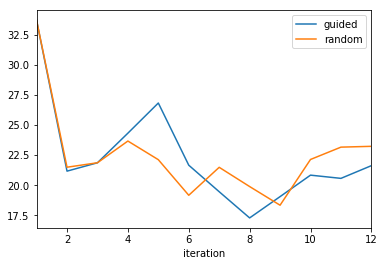

In [246]:
error_summary_guided['random'] =  error_summary_random['error']
plotErrors(error_summary_guided)

## Ex2

In [249]:
poolDF_guided = pd.DataFrame()
poolDF_random = pd.DataFrame()

error_summary_guided = pd.DataFrame()
error_summary_random = pd.DataFrame()

## Initializing pool
for sensor in initialPool:
    
    currentDataframe = sensors_datasets[sensor]
    poolDF_guided = poolDF_guided.append(currentDataframe)
    poolDF_random = poolDF_random.append(currentDataframe)
    usedSensors_guided.append(sensor)
    usedSensors_random.append(sensor)

    
iteration = 0

while( len(usedSensors_guided) < len(poolOfSensors) ):
    
    print('Len guided: ', len(usedSensors_guided))
    print('Len pool: ', len(poolOfSensors))
    
    iteration += 1
    
    print('Iteration: ', iteration)
    
    ## running regressor for both random and guided
    print('\tRunning estimators...')
    regressor_guided, abs_error_guided = runEstimator(poolDF_guided)
    regressor_random, abs_error_random = runEstimator(poolDF_random)
    
    print('\t\terror guided: ', abs_error_guided)
    print('\t\terror random: ', abs_error_random)
    
    ## saving error in a dataframe
    error_summary_guided = error_summary_guided.append({'error': abs_error_guided, 'iteration':iteration}, ignore_index=True)
    error_summary_random = error_summary_random.append({'error': abs_error_random, 'iteration':iteration}, ignore_index=True)
    
    ## ranking remaining sensors
    sensors_rank = pd.DataFrame()
    
    print('\tRanking remaining...')
    for candidate in poolOfSensors:
        
        if(candidate not in usedSensors_guided):
            
            candidate_df = sensors_datasets[candidate]
            candidate_ci = rankSensors(candidate=candidate_df, regressor=regressor_guided)
            sensors_rank = sensors_rank.append({'sensor':candidate, 'ci':candidate_ci}, ignore_index=True)
    
    sensors_rank.sort_values(by='ci', ascending=False, inplace=True)
    chosen_sensor = sensors_rank.iloc[0]['sensor']
    print('Last Rank: ')
    print(sensors_rank)
    
    print('\tAdding to both random and guided...')
    ## appending new sensor to the guided dataframe
    chosen_dataframe = sensors_datasets[chosen_sensor]
    poolDF_guided = poolDF_guided.append(chosen_dataframe)
    usedSensors_guided.append(chosen_sensor)
    print('Added: ', chosen_sensor, ' to guided')
    
    ## appending new sensor to the random dataframe
    flag = True
    while(flag):
        random_choice = random.choice(poolOfSensors)
        if(random_choice not in usedSensors_random):
            random_dataframe = sensors_datasets[random_choice]
            poolDF_random = poolDF_random.append(random_dataframe)
            usedSensors_random.append(random_choice)
            flag = False
    
    print('Added: ', random_choice, ' to random')

Len guided:  5
Len pool:  17
Iteration:  1
	Running estimators...
		error guided:  33.71822173348701
		error random:  33.71822173348701
	Ranking remaining...
Last Rank: 
            ci                        sensor
0   220.907115  sonycnode-b827eb3e842e.sonyc
8   202.013699  sonycnode-b827ebad073b.sonyc
10  149.620041  sonycnode-b827ebc7f772.sonyc
6   148.977326  sonycnode-b827eb9bed23.sonyc
4   146.862438  sonycnode-b827eb86d458.sonyc
2   136.237639  sonycnode-b827eb815321.sonyc
11  121.287913  sonycnode-b827ebefb215.sonyc
3   109.701763  sonycnode-b827eb820cfe.sonyc
1   106.571723  sonycnode-b827eb42bd4a.sonyc
5   106.033665  sonycnode-b827eb8e2420.sonyc
7   102.884177  sonycnode-b827eb9d0e7f.sonyc
9    95.292577  sonycnode-b827ebb40450.sonyc
	Adding to both random and guided...
Added:  sonycnode-b827eb3e842e.sonyc  to guided
Added:  sonycnode-b827eb8e2420.sonyc  to random
Len guided:  6
Len pool:  17
Iteration:  2
	Running estimators...
		error guided:  27.060580742397196
		error ra

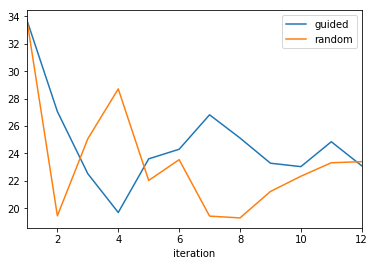

In [250]:
error_summary_guided['random'] =  error_summary_random['error']
plotErrors(error_summary_guided)

## Ex3

In [253]:
poolDF_guided = pd.DataFrame()
poolDF_random = pd.DataFrame()

error_summary_guided = pd.DataFrame()
error_summary_random = pd.DataFrame()

## Initializing pool
for sensor in initialPool:
    
    currentDataframe = sensors_datasets[sensor]
    poolDF_guided = poolDF_guided.append(currentDataframe)
    poolDF_random = poolDF_random.append(currentDataframe)
    usedSensors_guided.append(sensor)
    usedSensors_random.append(sensor)

    
iteration = 0

while( len(usedSensors_guided) < len(poolOfSensors) ):
    
    print('Len guided: ', len(usedSensors_guided))
    print('Len pool: ', len(poolOfSensors))
    
    iteration += 1
    
    print('Iteration: ', iteration)
    
    ## running regressor for both random and guided
    print('\tRunning estimators...')
    regressor_guided, abs_error_guided = runEstimator(poolDF_guided)
    regressor_random, abs_error_random = runEstimator(poolDF_random)
    
    print('\t\terror guided: ', abs_error_guided)
    print('\t\terror random: ', abs_error_random)
    
    ## saving error in a dataframe
    error_summary_guided = error_summary_guided.append({'error': abs_error_guided, 'iteration':iteration}, ignore_index=True)
    error_summary_random = error_summary_random.append({'error': abs_error_random, 'iteration':iteration}, ignore_index=True)
    
    ## ranking remaining sensors
    sensors_rank = pd.DataFrame()
    
    print('\tRanking remaining...')
    for candidate in poolOfSensors:
        
        if(candidate not in usedSensors_guided):
            
            candidate_df = sensors_datasets[candidate]
            candidate_ci = rankSensors(candidate=candidate_df, regressor=regressor_guided)
            sensors_rank = sensors_rank.append({'sensor':candidate, 'ci':candidate_ci}, ignore_index=True)
    
    sensors_rank.sort_values(by='ci', ascending=False, inplace=True)
    chosen_sensor = sensors_rank.iloc[0]['sensor']
    print('Last Rank: ')
    print(sensors_rank)
    
    print('\tAdding to both random and guided...')
    ## appending new sensor to the guided dataframe
    chosen_dataframe = sensors_datasets[chosen_sensor]
    poolDF_guided = poolDF_guided.append(chosen_dataframe)
    usedSensors_guided.append(chosen_sensor)
    print('Added: ', chosen_sensor, ' to guided')
    
    ## appending new sensor to the random dataframe
    flag = True
    while(flag):
        random_choice = random.choice(poolOfSensors)
        if(random_choice not in usedSensors_random):
            random_dataframe = sensors_datasets[random_choice]
            poolDF_random = poolDF_random.append(random_dataframe)
            usedSensors_random.append(random_choice)
            flag = False
    
    print('Added: ', random_choice, ' to random')

Len guided:  5
Len pool:  17
Iteration:  1
	Running estimators...
		error guided:  33.71822173348701
		error random:  33.71822173348701
	Ranking remaining...
Last Rank: 
            ci                        sensor
3   166.660390  sonycnode-b827eb820cfe.sonyc
9   147.873845  sonycnode-b827ebb40450.sonyc
7   145.480255  sonycnode-b827eb9d0e7f.sonyc
4   137.315819  sonycnode-b827eb86d458.sonyc
6   124.890665  sonycnode-b827eb9bed23.sonyc
1   123.054543  sonycnode-b827eb42bd4a.sonyc
0   114.692383  sonycnode-b827eb3e842e.sonyc
5   113.368118  sonycnode-b827eb8e2420.sonyc
10  106.254308  sonycnode-b827ebc7f772.sonyc
11  105.038284  sonycnode-b827ebefb215.sonyc
2   102.592220  sonycnode-b827eb815321.sonyc
8    92.737476  sonycnode-b827ebad073b.sonyc
	Adding to both random and guided...
Added:  sonycnode-b827eb820cfe.sonyc  to guided
Added:  sonycnode-b827eb3e842e.sonyc  to random
Len guided:  6
Len pool:  17
Iteration:  2
	Running estimators...
		error guided:  23.55102796599795
		error ran

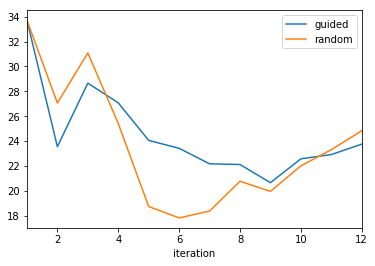

In [254]:
error_summary_guided['random'] =  error_summary_random['error']
plotErrors(error_summary_guided)

## Ex4 (Testing on a different set)

In [263]:
poolDF_guided = pd.DataFrame()
poolDF_random = pd.DataFrame()

error_summary_guided = pd.DataFrame()
error_summary_random = pd.DataFrame()

## Initializing pool
for sensor in initialPool:
    
    currentDataframe = sensors_datasets[sensor]
    poolDF_guided = poolDF_guided.append(currentDataframe)
    poolDF_random = poolDF_random.append(currentDataframe)
    usedSensors_guided.append(sensor)
    usedSensors_random.append(sensor)

    
iteration = 0

while( len(usedSensors_guided) < len(poolOfSensors) ):
    
    print('Len guided: ', len(usedSensors_guided))
    print('Len pool: ', len(poolOfSensors))
    
    iteration += 1
    
    print('Iteration: ', iteration)
    
    ## running regressor for both random and guided
    print('\tRunning estimators...')
    regressor_guided, abs_error_guided = runEstimator(poolDF_guided)
    regressor_random, abs_error_random = runEstimator(poolDF_random)
    
    print('\t\terror guided: ', abs_error_guided)
    print('\t\terror random: ', abs_error_random)
    
    for testingSensor in testingSet:
        
        testingDF = sensors_datasets[testingSensor]
        currentError_guided = errorSensor(testingDF, regressor_guided)
        currentError_random = errorSensor(testingDF, regressor_random)
            
        ## saving error in a dataframe
        error_summary_guided = error_summary_guided.append({'error': currentError_guided, 'sensor':testingSensor, 'iteration':iteration}, ignore_index=True)
        error_summary_random = error_summary_random.append({'error': currentError_random, 'sensor':testingSensor, 'iteration':iteration}, ignore_index=True)
    
    ## ranking remaining sensors
    sensors_rank = pd.DataFrame()
    
    print('\tRanking remaining...')
    for candidate in poolOfSensors:
        
        if( (candidate not in usedSensors_guided) and (candidate not in testingSet) ):
            
            candidate_df = sensors_datasets[candidate]
            candidate_ci = rankSensors(candidate=candidate_df, regressor=regressor_guided)
            sensors_rank = sensors_rank.append({'sensor':candidate, 'ci':candidate_ci}, ignore_index=True)
    
    sensors_rank.sort_values(by='ci', ascending=False, inplace=True)
    chosen_sensor = sensors_rank.iloc[0]['sensor']
    print('Last Rank: ')
    print(sensors_rank)
    
    print('\tAdding to both random and guided...')
    ## appending new sensor to the guided dataframe
    chosen_dataframe = sensors_datasets[chosen_sensor]
    poolDF_guided = poolDF_guided.append(chosen_dataframe)
    usedSensors_guided.append(chosen_sensor)
    print('Added: ', chosen_sensor, ' to guided')
    
    ## appending new sensor to the random dataframe
    flag = True
    while(flag):
        random_choice = random.choice(poolOfSensors)
        if( (random_choice not in usedSensors_random) and (random_choice not in testingSet)):
            random_dataframe = sensors_datasets[random_choice]
            poolDF_random = poolDF_random.append(random_dataframe)
            usedSensors_random.append(random_choice)
            flag = False
    
    print('Added: ', random_choice, ' to random')

Len guided:  2
Len pool:  17
Iteration:  1
	Running estimators...
		error guided:  41.853794940474295
		error random:  41.853794940474295
	Ranking remaining...
Last Rank: 
          ci                        sensor
15  4.089075  sonycnode-b827ebefb215.sonyc
2   2.482674  sonycnode-b827eb3e842e.sonyc
1   2.443447  sonycnode-b827eb29eb77.sonyc
3   2.070324  sonycnode-b827eb42bd4a.sonyc
9   2.050902  sonycnode-b827eb8e2420.sonyc
8   1.996519  sonycnode-b827eb86d458.sonyc
0   1.631447  sonycnode-b827eb132382.sonyc
4   1.385730  sonycnode-b827eb44506f.sonyc
10  1.185596  sonycnode-b827eb9bed23.sonyc
14  1.167628  sonycnode-b827ebc7f772.sonyc
13  1.088455  sonycnode-b827ebb40450.sonyc
11  0.850431  sonycnode-b827eb9d0e7f.sonyc
12  0.820416  sonycnode-b827ebad073b.sonyc
6   0.695278  sonycnode-b827eb815321.sonyc
5   0.518676  sonycnode-b827eb73e772.sonyc
7   0.368301  sonycnode-b827eb820cfe.sonyc
	Adding to both random and guided...
Added:  sonycnode-b827ebefb215.sonyc  to guided
Added:  sony

		error guided:  26.964141625549384
		error random:  34.33357953905082
	Ranking remaining...
Last Rank: 
          ci                        sensor
1  53.406186  sonycnode-b827eb8e2420.sonyc
4  27.650455  sonycnode-b827ebad073b.sonyc
5  26.237976  sonycnode-b827ebb40450.sonyc
2  10.952158  sonycnode-b827eb9bed23.sonyc
0   7.493485  sonycnode-b827eb42bd4a.sonyc
3   5.306454  sonycnode-b827eb9d0e7f.sonyc
	Adding to both random and guided...
Added:  sonycnode-b827eb8e2420.sonyc  to guided
Added:  sonycnode-b827eb42bd4a.sonyc  to random
Len guided:  13
Len pool:  17
Iteration:  12
	Running estimators...
		error guided:  22.717979316504657
		error random:  27.22365691444827
	Ranking remaining...
Last Rank: 
          ci                        sensor
4  19.016149  sonycnode-b827ebb40450.sonyc
1  18.488498  sonycnode-b827eb9bed23.sonyc
3   7.487908  sonycnode-b827ebad073b.sonyc
0   5.444290  sonycnode-b827eb42bd4a.sonyc
2   4.681497  sonycnode-b827eb9d0e7f.sonyc
	Adding to both random and gui

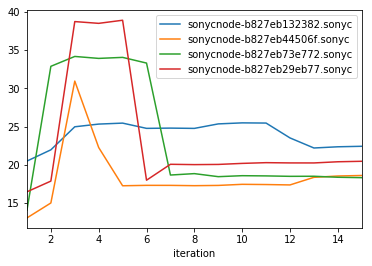

In [265]:
fig,ax= plt.subplots()

for sensor in testingSet:
    current = error_summary_guided[error_summary_guided['sensor'] == sensor]
    current.plot(x='iteration',y='error', ax=ax,label=sensor)
    
fig.show()

## Ex5 (Random picking)

In [ ]:
for testingSensor in poolOfSensors:
    
    testingDF = pd.DataFrame()
    
    for timeslice in sensors_datasets[testingSensor]:
        testingDF = testingDF.append(sensors_datasets[testingSensor][timeslice])
    
    for randomIter in range(0,5):
    
        chosenSensors = []
        current_period = 0
        trainingDF = pd.DataFrame()
        errorSummary_df = pd.DataFrame()
        while( len(chosenSensors) < (len(poolOfSensors) - 3) ):

            
            random_choice = random.choice(poolOfSensors)
            print('Random Chouice: ', random_choice)
            if( (random_choice != testingSensor) and (random_choice not in chosenSensors )):

                chosenSensors.append(random_choice)
                for sensor in chosenSensors:
                    trainingDF = trainingDF.append(sensors_datasets[sensor][current_period])
                
                if(trainingDF.shape[0] != 0):
                    
                    regressor_random, abs_error_random = runEstimator(trainingDF)
                    abs_error = errorSensor(testingDF, regressor_random)
                
                    errorSummary_df = errorSummary_df.append({'iteration':current_period, 'error':abs_error, 'newSensor':random_choice}, ignore_index=True)

                    current_period += 1
        
        print('Trained')
        if(errorSummary_df.shape[0] != 0):
            
            print('Saving ', testingSensor, '. Iter: ', randomIter)
            errorSummary_df.to_csv('../random_runs/' + testingSensor + '_' + str(randomIter) + '.csv')

            

Random Chouice:  sonycnode-b827ebad073b.sonyc
Random Chouice:  sonycnode-b827eb86d458.sonyc
Random Chouice:  sonycnode-b827eb132382.sonyc
Random Chouice:  sonycnode-b827ebad073b.sonyc
Random Chouice:  sonycnode-b827eb8e2420.sonyc
Random Chouice:  sonycnode-b827ebf9d204.sonyc
Random Chouice:  sonycnode-b827eb815321.sonyc
Random Chouice:  sonycnode-b827eb9d0e7f.sonyc
Random Chouice:  sonycnode-b827eb86d458.sonyc
Random Chouice:  sonycnode-b827eb44506f.sonyc
Random Chouice:  sonycnode-b827ebefb215.sonyc
Random Chouice:  sonycnode-b827ebefb215.sonyc
Random Chouice:  sonycnode-b827eb0fedda.sonyc
Random Chouice:  sonycnode-b827eb84deb5.sonyc
Random Chouice:  sonycnode-b827eb9d0e7f.sonyc
Random Chouice:  sonycnode-b827eb84deb5.sonyc
Random Chouice:  sonycnode-b827eb0fedda.sonyc
Random Chouice:  sonycnode-b827eb42bd4a.sonyc
Random Chouice:  sonycnode-b827ebb40450.sonyc
Random Chouice:  sonycnode-b827eb815321.sonyc
Random Chouice:  sonycnode-b827ebf9d204.sonyc
Random Chouice:  sonycnode-b827eb0

Random Chouice:  sonycnode-b827ebf9d204.sonyc
Random Chouice:  sonycnode-b827eb44506f.sonyc
Random Chouice:  sonycnode-b827eb0fedda.sonyc
Random Chouice:  sonycnode-b827eb0fedda.sonyc
Random Chouice:  sonycnode-b827eb9bed23.sonyc
Random Chouice:  sonycnode-b827eb9bed23.sonyc
Random Chouice:  sonycnode-b827eb820cfe.sonyc
Random Chouice:  sonycnode-b827eb86d458.sonyc
Random Chouice:  sonycnode-b827eb86d458.sonyc
Random Chouice:  sonycnode-b827eb3e842e.sonyc
Random Chouice:  sonycnode-b827ebefb215.sonyc
Random Chouice:  sonycnode-b827eb44506f.sonyc
Random Chouice:  sonycnode-b827ebf9d204.sonyc
Random Chouice:  sonycnode-b827eb29eb77.sonyc
Random Chouice:  sonycnode-b827eb132382.sonyc
Trained
Saving  sonycnode-b827eb0fedda.sonyc . Iter:  3
Random Chouice:  sonycnode-b827eb9d0e7f.sonyc
Random Chouice:  sonycnode-b827eb820cfe.sonyc
Random Chouice:  sonycnode-b827eb132382.sonyc
Random Chouice:  sonycnode-b827eb42bd4a.sonyc
Random Chouice:  sonycnode-b827eb29eb77.sonyc
Random Chouice:  sonycno

Random Chouice:  sonycnode-b827eb84deb5.sonyc
Random Chouice:  sonycnode-b827eb42bd4a.sonyc
Random Chouice:  sonycnode-b827eb8e2420.sonyc
Random Chouice:  sonycnode-b827eb3e842e.sonyc
Random Chouice:  sonycnode-b827eb73e772.sonyc
Random Chouice:  sonycnode-b827ebad073b.sonyc
Random Chouice:  sonycnode-b827eb3e842e.sonyc
Random Chouice:  sonycnode-b827eb86d458.sonyc
Random Chouice:  sonycnode-b827eb132382.sonyc
Random Chouice:  sonycnode-b827eb29eb77.sonyc
Random Chouice:  sonycnode-b827eb8e2420.sonyc
Random Chouice:  sonycnode-b827eb815321.sonyc
Random Chouice:  sonycnode-b827eb815321.sonyc
Random Chouice:  sonycnode-b827eb29eb77.sonyc
Random Chouice:  sonycnode-b827eb9d0e7f.sonyc
Trained
Saving  sonycnode-b827eb132382.sonyc . Iter:  3
Random Chouice:  sonycnode-b827eb0fedda.sonyc
Random Chouice:  sonycnode-b827eb8e2420.sonyc
Random Chouice:  sonycnode-b827eb3e842e.sonyc
Random Chouice:  sonycnode-b827ebf9d204.sonyc
Random Chouice:  sonycnode-b827eb9bed23.sonyc
Random Chouice:  sonycno

Random Chouice:  sonycnode-b827eb8e2420.sonyc
Random Chouice:  sonycnode-b827eb9d0e7f.sonyc
Random Chouice:  sonycnode-b827eb84deb5.sonyc
Random Chouice:  sonycnode-b827eb29eb77.sonyc
Random Chouice:  sonycnode-b827ebc7f772.sonyc
Random Chouice:  sonycnode-b827eb8e2420.sonyc
Random Chouice:  sonycnode-b827ebefb215.sonyc
Random Chouice:  sonycnode-b827eb44506f.sonyc
Random Chouice:  sonycnode-b827eb3e842e.sonyc
Random Chouice:  sonycnode-b827eb8e2420.sonyc
Random Chouice:  sonycnode-b827eb820cfe.sonyc
Random Chouice:  sonycnode-b827eb132382.sonyc
Random Chouice:  sonycnode-b827eb44506f.sonyc
Random Chouice:  sonycnode-b827eb9bed23.sonyc
Random Chouice:  sonycnode-b827eb44506f.sonyc
Random Chouice:  sonycnode-b827ebad073b.sonyc
Random Chouice:  sonycnode-b827ebc7f772.sonyc
Random Chouice:  sonycnode-b827ebf9d204.sonyc
Random Chouice:  sonycnode-b827ebefb215.sonyc
Random Chouice:  sonycnode-b827eb44506f.sonyc
Random Chouice:  sonycnode-b827eb84deb5.sonyc
Random Chouice:  sonycnode-b827eb0

Random Chouice:  sonycnode-b827eb815321.sonyc
Random Chouice:  sonycnode-b827eb0fedda.sonyc
Random Chouice:  sonycnode-b827ebb40450.sonyc
Random Chouice:  sonycnode-b827ebad073b.sonyc
Random Chouice:  sonycnode-b827eb44506f.sonyc
Random Chouice:  sonycnode-b827eb84deb5.sonyc
Random Chouice:  sonycnode-b827eb84deb5.sonyc
Random Chouice:  sonycnode-b827ebc7f772.sonyc
Random Chouice:  sonycnode-b827ebad073b.sonyc
Random Chouice:  sonycnode-b827eb86d458.sonyc
Random Chouice:  sonycnode-b827eb815321.sonyc
Random Chouice:  sonycnode-b827eb8e2420.sonyc
Random Chouice:  sonycnode-b827eb820cfe.sonyc
Random Chouice:  sonycnode-b827eb29eb77.sonyc
Random Chouice:  sonycnode-b827eb84deb5.sonyc
Random Chouice:  sonycnode-b827eb3e842e.sonyc
Random Chouice:  sonycnode-b827eb815321.sonyc
Random Chouice:  sonycnode-b827ebc7f772.sonyc
Random Chouice:  sonycnode-b827eb0fedda.sonyc
Random Chouice:  sonycnode-b827eb132382.sonyc
Random Chouice:  sonycnode-b827eb8e2420.sonyc
Random Chouice:  sonycnode-b827ebf

Random Chouice:  sonycnode-b827ebb40450.sonyc
Random Chouice:  sonycnode-b827eb0fedda.sonyc
Random Chouice:  sonycnode-b827eb3e842e.sonyc
Random Chouice:  sonycnode-b827ebc7f772.sonyc
Random Chouice:  sonycnode-b827eb84deb5.sonyc
Random Chouice:  sonycnode-b827eb84deb5.sonyc
Random Chouice:  sonycnode-b827ebad073b.sonyc
Random Chouice:  sonycnode-b827eb3e842e.sonyc
Random Chouice:  sonycnode-b827eb29eb77.sonyc
Random Chouice:  sonycnode-b827eb815321.sonyc
Random Chouice:  sonycnode-b827eb820cfe.sonyc
Random Chouice:  sonycnode-b827eb820cfe.sonyc
Random Chouice:  sonycnode-b827eb42bd4a.sonyc
Random Chouice:  sonycnode-b827eb132382.sonyc
Random Chouice:  sonycnode-b827eb44506f.sonyc
Trained
Saving  sonycnode-b827eb29eb77.sonyc . Iter:  3
Random Chouice:  sonycnode-b827eb9bed23.sonyc
Random Chouice:  sonycnode-b827eb42bd4a.sonyc
Random Chouice:  sonycnode-b827eb8e2420.sonyc
Random Chouice:  sonycnode-b827eb9d0e7f.sonyc
Random Chouice:  sonycnode-b827eb44506f.sonyc
Random Chouice:  sonycno

Random Chouice:  sonycnode-b827ebefb215.sonyc
Random Chouice:  sonycnode-b827eb132382.sonyc
Random Chouice:  sonycnode-b827ebefb215.sonyc
Random Chouice:  sonycnode-b827eb44506f.sonyc
Random Chouice:  sonycnode-b827eb86d458.sonyc
Random Chouice:  sonycnode-b827eb42bd4a.sonyc
Random Chouice:  sonycnode-b827eb73e772.sonyc
Random Chouice:  sonycnode-b827eb9d0e7f.sonyc
Random Chouice:  sonycnode-b827eb8e2420.sonyc
Random Chouice:  sonycnode-b827eb9bed23.sonyc
Random Chouice:  sonycnode-b827eb815321.sonyc
Random Chouice:  sonycnode-b827eb29eb77.sonyc
Random Chouice:  sonycnode-b827eb815321.sonyc
Random Chouice:  sonycnode-b827eb8e2420.sonyc
Random Chouice:  sonycnode-b827eb9d0e7f.sonyc
Random Chouice:  sonycnode-b827ebb40450.sonyc
Random Chouice:  sonycnode-b827eb44506f.sonyc
Random Chouice:  sonycnode-b827ebefb215.sonyc
Random Chouice:  sonycnode-b827eb9bed23.sonyc
Random Chouice:  sonycnode-b827eb29eb77.sonyc
Random Chouice:  sonycnode-b827eb84deb5.sonyc
Random Chouice:  sonycnode-b827eb8

Random Chouice:  sonycnode-b827eb9d0e7f.sonyc
Random Chouice:  sonycnode-b827eb44506f.sonyc
Random Chouice:  sonycnode-b827eb84deb5.sonyc
Random Chouice:  sonycnode-b827ebf9d204.sonyc
Random Chouice:  sonycnode-b827eb815321.sonyc
Random Chouice:  sonycnode-b827eb44506f.sonyc
Random Chouice:  sonycnode-b827eb42bd4a.sonyc
Random Chouice:  sonycnode-b827eb86d458.sonyc
Random Chouice:  sonycnode-b827eb815321.sonyc
Random Chouice:  sonycnode-b827eb42bd4a.sonyc
Random Chouice:  sonycnode-b827eb29eb77.sonyc
Random Chouice:  sonycnode-b827eb44506f.sonyc
Random Chouice:  sonycnode-b827eb42bd4a.sonyc
Random Chouice:  sonycnode-b827eb9d0e7f.sonyc
Random Chouice:  sonycnode-b827eb0fedda.sonyc
Random Chouice:  sonycnode-b827ebb40450.sonyc
Random Chouice:  sonycnode-b827eb29eb77.sonyc
Random Chouice:  sonycnode-b827eb8e2420.sonyc
Trained
Saving  sonycnode-b827eb820cfe.sonyc . Iter:  2
Random Chouice:  sonycnode-b827ebad073b.sonyc
Random Chouice:  sonycnode-b827eb815321.sonyc
Random Chouice:  sonycno

Random Chouice:  sonycnode-b827ebefb215.sonyc
Random Chouice:  sonycnode-b827ebf9d204.sonyc
Random Chouice:  sonycnode-b827eb9bed23.sonyc
Random Chouice:  sonycnode-b827eb815321.sonyc
Random Chouice:  sonycnode-b827ebc7f772.sonyc
Random Chouice:  sonycnode-b827eb9bed23.sonyc
Random Chouice:  sonycnode-b827ebefb215.sonyc
Random Chouice:  sonycnode-b827eb29eb77.sonyc
Random Chouice:  sonycnode-b827eb9bed23.sonyc
Random Chouice:  sonycnode-b827ebad073b.sonyc
Random Chouice:  sonycnode-b827eb29eb77.sonyc
Random Chouice:  sonycnode-b827eb9bed23.sonyc
Random Chouice:  sonycnode-b827ebb40450.sonyc
Random Chouice:  sonycnode-b827eb73e772.sonyc
Random Chouice:  sonycnode-b827ebf9d204.sonyc
Random Chouice:  sonycnode-b827eb815321.sonyc
Random Chouice:  sonycnode-b827eb42bd4a.sonyc
Random Chouice:  sonycnode-b827eb9d0e7f.sonyc
Random Chouice:  sonycnode-b827eb73e772.sonyc
Random Chouice:  sonycnode-b827eb44506f.sonyc
Random Chouice:  sonycnode-b827eb8e2420.sonyc
Random Chouice:  sonycnode-b827ebf

Random Chouice:  sonycnode-b827eb9d0e7f.sonyc
Random Chouice:  sonycnode-b827eb8e2420.sonyc
Random Chouice:  sonycnode-b827eb815321.sonyc
Random Chouice:  sonycnode-b827eb815321.sonyc
Random Chouice:  sonycnode-b827eb86d458.sonyc
Random Chouice:  sonycnode-b827eb73e772.sonyc
Random Chouice:  sonycnode-b827ebf9d204.sonyc
Random Chouice:  sonycnode-b827eb9d0e7f.sonyc
Random Chouice:  sonycnode-b827eb9d0e7f.sonyc
Random Chouice:  sonycnode-b827ebc7f772.sonyc
Random Chouice:  sonycnode-b827ebefb215.sonyc
Random Chouice:  sonycnode-b827eb84deb5.sonyc
Random Chouice:  sonycnode-b827eb8e2420.sonyc
Random Chouice:  sonycnode-b827ebf9d204.sonyc
Random Chouice:  sonycnode-b827eb815321.sonyc
Random Chouice:  sonycnode-b827eb9d0e7f.sonyc
Random Chouice:  sonycnode-b827eb132382.sonyc
Random Chouice:  sonycnode-b827eb815321.sonyc
Random Chouice:  sonycnode-b827eb820cfe.sonyc
Random Chouice:  sonycnode-b827ebb40450.sonyc
Random Chouice:  sonycnode-b827eb29eb77.sonyc
Random Chouice:  sonycnode-b827eb3

Random Chouice:  sonycnode-b827eb86d458.sonyc
Random Chouice:  sonycnode-b827eb9bed23.sonyc
Random Chouice:  sonycnode-b827eb84deb5.sonyc
Random Chouice:  sonycnode-b827eb3e842e.sonyc
Random Chouice:  sonycnode-b827eb3e842e.sonyc
Random Chouice:  sonycnode-b827eb0fedda.sonyc
Random Chouice:  sonycnode-b827eb44506f.sonyc
Random Chouice:  sonycnode-b827ebf9d204.sonyc
Random Chouice:  sonycnode-b827eb44506f.sonyc
Random Chouice:  sonycnode-b827eb8e2420.sonyc
Random Chouice:  sonycnode-b827eb9d0e7f.sonyc
Random Chouice:  sonycnode-b827eb815321.sonyc
Random Chouice:  sonycnode-b827eb8e2420.sonyc
Random Chouice:  sonycnode-b827ebad073b.sonyc
Random Chouice:  sonycnode-b827ebf9d204.sonyc
Random Chouice:  sonycnode-b827eb820cfe.sonyc
Random Chouice:  sonycnode-b827eb9d0e7f.sonyc
Random Chouice:  sonycnode-b827eb44506f.sonyc
Random Chouice:  sonycnode-b827eb132382.sonyc
Random Chouice:  sonycnode-b827ebf9d204.sonyc
Random Chouice:  sonycnode-b827eb29eb77.sonyc
Random Chouice:  sonycnode-b827eb3

Random Chouice:  sonycnode-b827eb8e2420.sonyc
Random Chouice:  sonycnode-b827eb9bed23.sonyc
Random Chouice:  sonycnode-b827eb8e2420.sonyc
Random Chouice:  sonycnode-b827ebad073b.sonyc
Random Chouice:  sonycnode-b827eb3e842e.sonyc
Random Chouice:  sonycnode-b827eb86d458.sonyc
Random Chouice:  sonycnode-b827eb820cfe.sonyc
Random Chouice:  sonycnode-b827ebad073b.sonyc
Random Chouice:  sonycnode-b827eb42bd4a.sonyc
Random Chouice:  sonycnode-b827eb86d458.sonyc
Random Chouice:  sonycnode-b827eb29eb77.sonyc
Random Chouice:  sonycnode-b827eb29eb77.sonyc
Random Chouice:  sonycnode-b827eb9d0e7f.sonyc
Random Chouice:  sonycnode-b827eb3e842e.sonyc
Random Chouice:  sonycnode-b827ebb40450.sonyc
Random Chouice:  sonycnode-b827eb3e842e.sonyc
Random Chouice:  sonycnode-b827eb815321.sonyc
Random Chouice:  sonycnode-b827eb0fedda.sonyc
Random Chouice:  sonycnode-b827eb44506f.sonyc
Random Chouice:  sonycnode-b827eb44506f.sonyc
Random Chouice:  sonycnode-b827eb44506f.sonyc
Random Chouice:  sonycnode-b827eb8

## Helper Functions

In [24]:
def getSensorLocation(lat, lng):
    
    ## TODO: Refactor function return
    ## get neighboorhood ID of a coordinate
    point = Point(lng, lat)
    taxi_regions['intersect'] = taxi_regions.apply(lambda row: row['geometry'].intersects(point), axis=1)
    region =  taxi_regions[taxi_regions['intersect'] == True]['LocationID']
    return region.values[0]



def rankSensors(candidate, regressor):
    
    candidate_X = candidate[['DOB', 'twitter', 'noise']]
    candidate_y = candidate[['SPL']]

    candidate_train, candidate_test, candidate_train, candidate_test = train_test_split(X, y, test_size=0.3, shuffle=False)
            
    forestCI = fci.random_forest_error(regressor, X_train , X_test)
    mean_ci = np.mean(forestCI)
    
    return mean_ci

def runEstimator(poolDF):
    
    regressor = RandomForestRegressor(n_estimators=2000, random_state=42, n_jobs=-1)

    X = poolDF[['DOB', 'twitter', 'noise', 'hour_sin', 'hour_cos']]
    y = poolDF[['SPL']]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    
    abs_error = mean_absolute_error(y_test, y_pred)

    return regressor, abs_error


def errorSensor(sensorDF, regressor):
    
    X_test = sensorDF[['DOB', 'twitter', 'noise', 'hour_sin', 'hour_cos']]
    y_test = sensorDF[['SPL']]
    
    y_pred = regressor.predict(X_test)
    
    abs_error = mean_absolute_error(y_test, y_pred) 
    
    return abs_error

def spatialJoin(sensorLat, sensorLon, sensorID, geoDataFrame):
    
    d = 300 # meters
    n_points = 20
    angles = np.linspace(0, 360, n_points)
    center = shapely.geometry.Point(sensorLon, sensorLat)
    polygon = Polygon(geog.propagate(center, angles, d))
    
    sinpoly = gpd.GeoDataFrame(crs={'init': 'epsg:4326'})
    sinpoly = sinpoly.append({'geometry': polygon, 'sensorID':sensorID}, ignore_index=True) 
    sinpoly = sinpoly.to_crs({'init':'epsg:3857'})
    
    dataframe = gpd.tools.sjoin(geoDataFrame, sinpoly, how='inner', op="within")
    
    return dataframe

def plotErrors(errorDF):
    
    fig,ax= plt.subplots()

    errorDF['random'] =  error_summary_random['error']

    errorDF.plot(x='iteration',y='error', ax=ax,label='guided')
    errorDF.plot(x='iteration',y='random', ax=ax,label='random')
    
    fig.show()